In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import hyperiax
from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp
from hyperiax.execution import LevelwiseTreeExecutor, DependencyTreeExecutor
from hyperiax.models import UpLambda, DownLambda
from hyperiax.models.functional import pass_up
import jax
from functools import partial

In [7]:
key = PRNGKey(0)

# Estimation of inner nodes of an evolutionary tree

In this notebook we illustrate how to use Hyperiax for estimating inner nodes of an (evolutionary) tree, given 

- observations of the leaf-nodes and
- knowledge of the tree topology (number of nodes, the edges connecting them and edge lengths).

This is a basic problem in the field of Phylogenetic Comparative Methods.
We will be particularly interested in the root-node estimate, which can be interpreted as the phylogenetic mean of the observations. 
We will use a very simple estimator of the inner nodes; any inner node will be estimated as the weighted mean of its children. I.e. $x = \sum_{i=1}^k c_i \cdot 1/w_i$, where $w_i$ is the length of the edge between the inner node $x$ and its child $c_i$. We assume that all nodes are 2-dimensional vectors, which allows for nice visualizations.

Furthermore we show how to use Hyperiax for simulating trees (i.e. inner nodes and leaf nodes) based on the Brownian motion model; an edge of length T corresponds to a Brownian motion run for a duration of T. This allows us to evaluate our estimates of inner nodes since we know the true values in this case.

**Content of the notebook**

1. we create the tree with a chosen topology
2. we simulate node values, based on the Brownian motion model
3. we estimate inner nodes based on a simulated tree
4. we show how to compute the estimations more conveniently using 'prebuilt' functions


### 1. Creating the Tree

First, we initialize a tree. This creates a tree with a chosen topology. The node values and edge-lengths will be random. We create a tree with 3 levels and two children at each level. See also the notebook 'Tree building' for more details.

``jaxtrees.tree.initializers.initialize_noise`` Will place a `shape` shaped sample from the unit normal $\mathcal{N}(0,1)$ in `node.data`, with the key `noise`

In [11]:
tree = hyperiax.tree.builders.THeight_legacy(3,3)  
subkey, key = split(key)
noise_tree = hyperiax.tree.initializers.initialize_noise(tree, key, (2,))

We then iterate over all of the nodes in the tree breadth first using `iter_bfs()`, and for each node, we set the edge_length to be a random number in the unit interval

In [12]:
for i, node in enumerate(noise_tree.iter_bfs()):
    key, subkey = split(key)
    node.data['edge_length'] = jax.random.uniform(subkey, (1,))

In [13]:
tree.plot_tree_text()

                          *
        ┌─────────────────┼─────────────────┐
        *                 *                 *        
  ┌─────┼─────┐     ┌─────┼─────┐     ┌─────┼─────┐  
  *     *     *     *     *     *     *     *     *  
┌─┼─┐ ┌─┼─┐ ┌─┼─┐ ┌─┼─┐ ┌─┼─┐ ┌─┼─┐ ┌─┼─┐ ┌─┼─┐ ┌─┼─┐
* * * * * * * * * * * * * * * * * * * * * * * * * * *


### 2. Simulating node values

Now we define a down function to correlate the nodes. Notice that since each node was sampled independently, they are currently just all iid. We will write a down function which ensures that each child node of an inner node $x$ is a sample from a (standard) Brownian motion starting at $x$ and stopped at time $T$, where $T$ equals the length of the edge connecting $x$ and the child $c$. Such a sample can be obtained by computing $\sqrt{T} \cdot N + x$, where $N$ is a sample from a standard 2D Normal distribution. 

The `down` function operates on an edge $(u,v)$, where we let $u$ be the source node, and $v$ be the target node. If we are going downwards in the tree (as in this case), $u$ is the parent and $v$ is the child. The goal of the `down` function is to calculate the new value of $v$, using both $u,v$ and an edge weight $t$.

We can query the data we need within nodes by specifying parameter names. In this case we need both the noise, and the edge length within each node. As well as the precalculated value in the parent of each node. All values in parent nodes are prefixed with `parent_`. So in this case, we simply have `noise`, `edge_length` from our node dict, and `parent_value` to get the `value` in the parents dictionary

Now, we want to set the value parameter in the node we just calculated. We do this by simply returning a dictionary specifying the values to overwrite. Notice, you do not need to return values you do not intend to change. In this example, we are not changing the edge lengths, and thus we just ignore them.

In [14]:
@jax.jit
def down(noise, edge_length,parent_value, **args):
    return {'value': jnp.sqrt(edge_length)*noise+parent_value}

Here, we set the root value to be the noise we sampled

In [15]:
noise_tree.root.data['value'] = noise_tree.root.data['noise']

Now we create both an executor and a model. The model object contains all user code related to the operations we wish to run on a tree. The executor object schedules execution within the tree, and is in charge of setting the data in the correct format, as well as batching things together and making sure everything runs in the correct order.

After we pass it our own custom down function, we give the executor the model, and run it on the noise tree.

In [16]:
downmodel = DownLambda(down_fn=down)
exe = DependencyTreeExecutor(downmodel, batch_size=5)
stoc_tree = exe.down(noise_tree)

We can plot the tree as follows

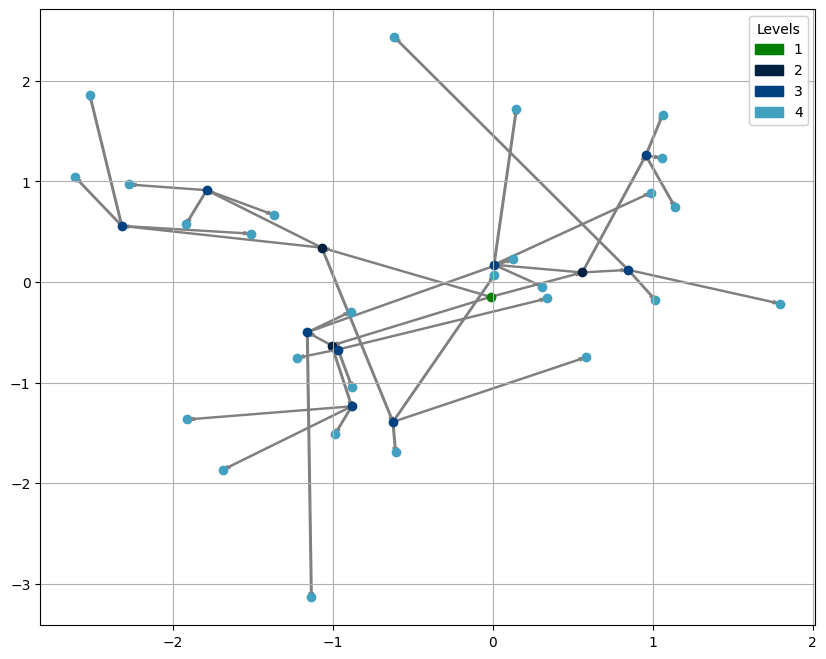

In [17]:
stoc_tree.plot_tree_2d(selector = lambda z:z['value'])

The green node represents the root, and the light blue nodes represent the leafs.

### 3. Estimating the inner nodes

Now we are going to mask out all of the data on the internal nodes, since this would most likely not be available to us in reality. 

We again use `iter_bfs()` to iterate over the tree, and simply delete whatever was stored in `value`

In [18]:
for node in stoc_tree.iter_bfs():
    if node.children:
        del node.data['value']

We now define 2 operations.

The up takes out 2 elements of each node `value` and `edge_length`, and passes them on as a message which is the tuple `(value, edge_length)`.

The fuse function, is responsible for taking all of the messages being passed by the up function, and combining them together in a single node. The fuse function can request data from the actual node by the same parameter naming convention, in this case we catch them using `**kwargs`. The stacked messages will be available through the the `messages` parameter. Since the data in each message is a tuple containing sizes `([2], [1])`, the node with $n$ children will recieve a tuple with sizes `([n,2], [n,1])`. We can unpack this tuple via the line `childrenxs, childrent = messages`. We now know that the shape of `childrenxs` is `[n,2]` and the value of `childrent` is `[n,1]`. This makes for a quick weighting with an einsum, and we return the resulting value as the `value` element in the nodes data.

In [19]:
up = pass_up('value', 'edge_length')

def fuse(child_value,child_edge_length, **kwargs):

    childrent_inv = 1 / child_edge_length

    result = jnp.einsum('c1,cd->d',childrent_inv, child_value)/childrent_inv.sum()
    return {'value': result}

upmodel = UpLambda(up, fuse)
root_exe = DependencyTreeExecutor(upmodel, batch_size=5)
calc_tree = root_exe.up(stoc_tree)

And we can plot the estimated tree as follows

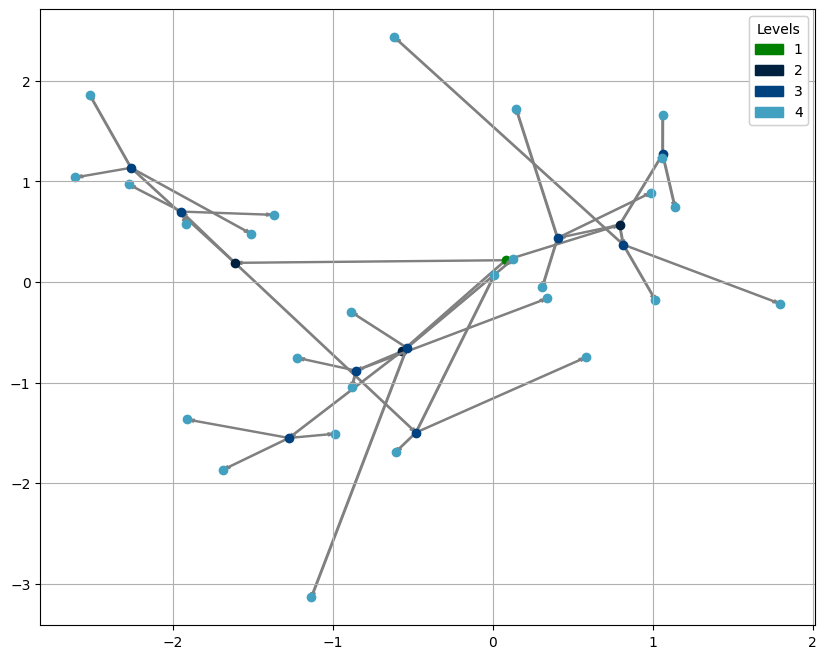

In [20]:
calc_tree.plot_tree_2d(selector=lambda z: z['value'])

### 4. Using prebuilts

Alternatively, we can use the cool prebuilts to do the same computations as above, but more conveniently!

In [21]:
from hyperiax.models.prebuilts import PhyloMeanModel

The `PhyloMeanExecutor` expects leaf nodes to all contain a field called `estimated_value`. Since we already know the exact values here, we can simply set them directly

In [22]:
for node in stoc_tree.iter_leaves():
    node.data['estimated_value'] = node.data['value']

In [23]:
pme = PhyloMeanModel()
exe = DependencyTreeExecutor(pme)

In [24]:
prebuilt_tree = exe.up(stoc_tree)

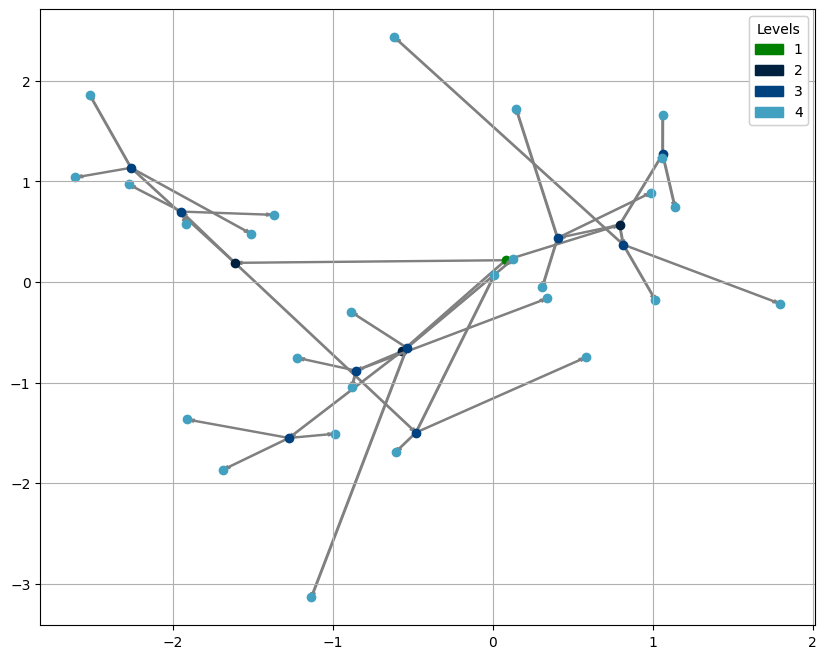

In [25]:
prebuilt_tree.plot_tree_2d(selector=lambda z: z['estimated_value'])